# Project: Investigate European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

# Questions

- in which countries does playing home affect the goals and wins of the home team most
- which season had the most and least goals per match
- what are the teams with the most home goals and away goals per match?


<a id='wrangling'></a>
## Data Wrangling

### General Properties

#### Loading Database

In [44]:
conn = sqlite3.connect('database.sqlite')

df_match = pd.read_sql("SELECT * FROM Match", conn)
df_country = pd.read_sql("SELECT * FROM Country", conn)
df_league = pd.read_sql("SELECT * FROM League", conn)
df_player = pd.read_sql("SELECT * FROM Player", conn)
df_team = pd.read_sql("SELECT * FROM Team", conn)
df_player_attributes = pd.read_sql("SELECT * FROM Player_Attributes", conn)
df_team_attributes = pd.read_sql("SELECT * FROM Team_Attributes", conn)

- all tables were loaded from the sqlite database
- the information from each table was written into a pandas dataframe 

In [45]:
df_country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [46]:
df_league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [47]:
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [48]:
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [49]:
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


#### Select relevant information

In [50]:
#define relevant columns for this project
columns_relevant = ['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id',
       'home_team_goal','away_team_goal']

df_match = df_match[columns_relevant]
df_match.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3
3,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0
4,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3


The Match table contains a lot of information and has a lot of columns. The tables relevant for this project were chosen.

In [51]:
# replace country_id with country name
df_match_merged = pd.merge(df_match, df_country[['name', 'id']], left_on='country_id', right_on='id', how='left')
df_match_merged = df_match_merged.rename(columns={'name': 'country'})
df_match_merged = df_match_merged.drop(columns=['country_id', 'id'])

# replace league_id with league name
df_match_merged = pd.merge(df_match_merged, df_league[['name', 'id']], left_on='league_id', right_on='id', how='left')
df_match_merged = df_match_merged.rename(columns={'name': 'league'})
df_match_merged = df_match_merged.drop(columns=['league_id', 'id'])

# replace team_api_id with team name
df_match_merged = pd.merge(df_match_merged, df_team[['team_long_name', 'team_api_id']], left_on='home_team_api_id', right_on='team_api_id', how='left')
df_match_merged = df_match_merged.rename(columns={'team_long_name': 'home_team'})
df_match_merged = df_match_merged.drop(columns=['home_team_api_id', 'team_api_id'])
df_match_merged = pd.merge(df_match_merged, df_team[['team_long_name', 'team_api_id']], left_on='away_team_api_id', right_on='team_api_id', how='left')
df_match_merged = df_match_merged.rename(columns={'team_long_name': 'away_team'})
df_match_merged = df_match_merged.drop(columns=['away_team_api_id', 'team_api_id'])

df_match_merged.head()

,season,stage,date,match_api_id,home_team_goal,away_team_goal,country,league,home_team,away_team
0,2008/2009,1,2008-08-17 00:00:00,492473,1,1,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC
1,2008/2009,1,2008-08-16 00:00:00,492474,0,0,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren
2,2008/2009,1,2008-08-16 00:00:00,492475,0,3,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht
3,2008/2009,1,2008-08-17 00:00:00,492476,5,0,Belgium,Belgium Jupiler League,KAA Gent,RAEC Mons
4,2008/2009,1,2008-08-16 00:00:00,492477,1,3,Belgium,Belgium Jupiler League,FCV Dender EH,Standard de Liège


- after having a view on each dataframe, the Match dataframe was chosen to be analyzed in this project.
- to make the infomation better understanable, the ids were merged so that the Match dataframe contains all the relevant information

#### Basic information on Match dataframe

In [52]:
df_match_relevant = df_match_merged.copy()

In [53]:
df_match_relevant.shape

(25979, 10)

In [54]:
df_match_relevant.describe()

,stage,match_api_id,home_team_goal,away_team_goal
count,25979.000000,2.597900e+04,25979.000000,25979.000000
mean,18.242773,1.195429e+06,1.544594,1.160938
std,10.407354,4.946279e+05,1.297158,1.142110
min,1.000000,4.831290e+05,0.000000,0.000000
25%,9.000000,7.684365e+05,1.000000,0.000000
50%,18.000000,1.147511e+06,1.000000,1.000000
75%,27.000000,1.709852e+06,2.000000,2.000000
max,38.000000,2.216672e+06,10.000000,9.000000


In [55]:
df_match_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   season          25979 non-null  object
 1   stage           25979 non-null  int64 
 2   date            25979 non-null  object
 3   match_api_id    25979 non-null  int64 
 4   home_team_goal  25979 non-null  int64 
 5   away_team_goal  25979 non-null  int64 
 6   country         25979 non-null  object
 7   league          25979 non-null  object
 8   home_team       25979 non-null  object
 9   away_team       25979 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.0+ MB


### Cleaning of the Match dataframe

- the data seems to be quite clean. On the first look, there are no missing data (null objects)
- also the coulmn names are written in lower cases and don't contian spaces

In [56]:
#look for duplivcate rows
df_match_relevant.drop_duplicates().shape

(25979, 10)

The dataframe does not contain duplicate rows.

<a id='eda'></a>
## Exploratory Data Analysis

### 1. General Data Analysis

In [57]:
# calculation the total number of goals per match
df_match_relevant['total_goals'] = df_match_relevant['home_team_goal'] + df_match_relevant['away_team_goal']

In [58]:
# home_team_goals per country
df_match_relevant.groupby('country').home_team_goal.sum()

country
Belgium        2781
England        4715
France         4265
Germany        3982
Italy          4528
Netherlands    4357
Poland         2678
Portugal       2890
Scotland       2607
Spain          4959
Switzerland    2365
Name: home_team_goal, dtype: int64

In [59]:
# matches per country
df_match_relevant.groupby('country').season.count()

country
Belgium        1728
England        3040
France         3040
Germany        2448
Italy          3017
Netherlands    2448
Poland         1920
Portugal       2052
Scotland       1824
Spain          3040
Switzerland    1422
Name: season, dtype: int64

In [60]:
# seasons
df_match_relevant.groupby('season').season.count()

season
2008/2009    3326
2009/2010    3230
2010/2011    3260
2011/2012    3220
2012/2013    3260
2013/2014    3032
2014/2015    3325
2015/2016    3326
Name: season, dtype: int64


### 2. How much does playing home impacts the number of goals shot by the home team in each country?

In [61]:
# home team goals per match per country
home_goals_per_match = df_match_relevant.groupby('country').home_team_goal.sum() / df_match_relevant.groupby('country').match_api_id.count()
home_goals_per_match.sort_values(inplace=True, ascending=False)

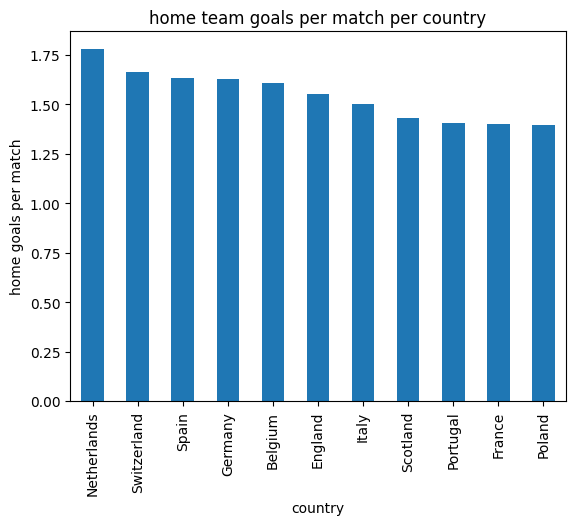

In [62]:
home_goals_per_match.plot(kind='bar')

# Optionally, add labels and titles
plt.xlabel('country')
plt.ylabel('home goals per match')
plt.title('home team goals per match per country')

# Show the plot
plt.show()

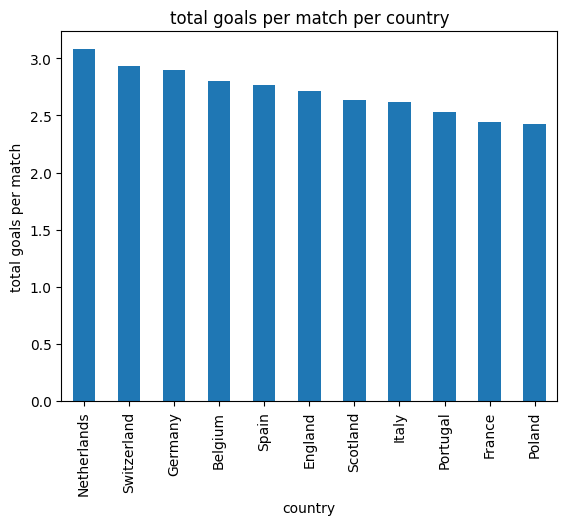

In [63]:
# total goals per match per country
total_goals_per_match = df_match_relevant.groupby('country').total_goals.sum() / df_match_relevant.groupby('country').match_api_id.count()
total_goals_per_match.sort_values(inplace=True, ascending=False)

total_goals_per_match.plot(kind='bar')

# Optionally, add labels and titles
plt.xlabel('country')
plt.ylabel('total goals per match')
plt.title('total goals per match per country')

# Show the plot
plt.show()


- in the Netherlands, the home team is shooting more goals than the other countries.
- however, the total goals shot in the Netherlands are also highest.
- If you look at Spain, they are third in home goals per match and only fifth in total goals per match
- it seems like playing home in spain has a bigger impact on scoring goals for the home team than in other countries

### 3. How much does playing of effects the home team to win?

In [64]:
df_match_relevant.head()

,season,stage,date,match_api_id,home_team_goal,away_team_goal,country,league,home_team,away_team,total_goals
0,2008/2009,1,2008-08-17 00:00:00,492473,1,1,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC,2
1,2008/2009,1,2008-08-16 00:00:00,492474,0,0,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren,0
2,2008/2009,1,2008-08-16 00:00:00,492475,0,3,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht,3
3,2008/2009,1,2008-08-17 00:00:00,492476,5,0,Belgium,Belgium Jupiler League,KAA Gent,RAEC Mons,5
4,2008/2009,1,2008-08-16 00:00:00,492477,1,3,Belgium,Belgium Jupiler League,FCV Dender EH,Standard de Liège,4


In [65]:
# add column that says if the home team won or not
df_match_relevant['home_team_win'] = df_match_relevant.apply(lambda x: True if x['home_team_goal'] > x['away_team_goal'] else False, axis=1)

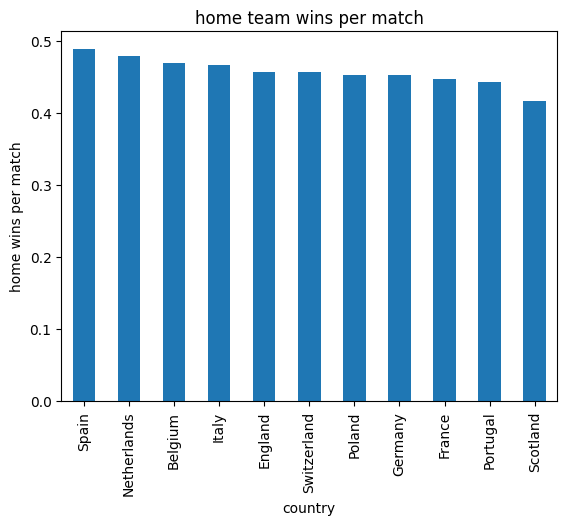

In [66]:
home_team_wins_per_match = df_match_relevant.groupby('country').home_team_win.sum() / df_match_relevant.groupby('country').match_api_id.count()
home_team_wins_per_match.sort_values(inplace=True, ascending=False)

home_team_wins_per_match.plot(kind='bar')

# Optionally, add labels and titles
plt.xlabel('country')
plt.ylabel('home wins per match')
plt.title('home team wins per match')

# Show the plot
plt.show()


In Spain, home teams are most likely to win a match compared to other countries.

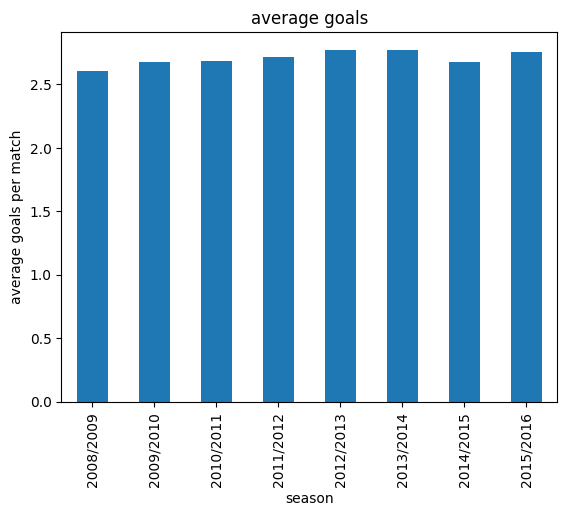

In [67]:
goals_per_match_per_season = df_match_relevant.groupby('season').total_goals.sum() / df_match_relevant.groupby('season').match_api_id.count()
goals_per_match_per_season.plot(kind='bar')

# Optionally, add labels and titles
plt.xlabel('season')
plt.ylabel('average goals per match')
plt.title('average goals')

# Show the plot
plt.show()

### 4. What was the season with the most and least goals per match?

In [68]:
goals_per_match_per_season.sort_values(inplace=True, ascending=False)
goals_per_match_per_season

season
2012/2013    2.772699
2013/2014    2.766821
2015/2016    2.754660
2011/2012    2.716460
2010/2011    2.683742
2014/2015    2.675789
2009/2010    2.672446
2008/2009    2.607336
dtype: float64

- 2012/2013 was the season with the most goals
- 2008/2009 was the season with the least goals

### 5. What are the teams with the most home goals and away goals per match?

In [69]:
home_goals_per_match_per_club = df_match_relevant.groupby('home_team').home_team_goal.sum() / df_match_relevant.groupby('home_team').match_api_id.count()
home_goals_per_match_per_club.sort_values(inplace=True, ascending=False)

home_goals_per_match_per_club

home_team
Real Madrid CF          3.322368
FC Barcelona            3.256579
FC Bayern Munich        2.808824
PSV                     2.720588
Ajax                    2.647059
                          ...   
Naval 1° de Maio        0.822222
Pescara                 0.789474
AC Arles-Avignon        0.736842
Córdoba CF              0.631579
SpVgg Greuther Fürth    0.588235
Length: 296, dtype: float64

Real Madrid CF, FC Barcelona and FC Bayern Munich are the teams with the most home goals per match.

In [70]:
away_goals_per_match_per_club = df_match_relevant.groupby('away_team').away_team_goal.sum() / df_match_relevant.groupby('away_team').match_api_id.count()
away_goals_per_match_per_club.sort_values(inplace=True, ascending=False)

away_goals_per_match_per_club

away_team
FC Barcelona               2.328947
Real Madrid CF             2.223684
Ajax                       2.110294
PSV                        2.073529
Celtic                     2.013158
                             ...   
Hércules Club de Fútbol    0.473684
Uniao da Madeira           0.470588
Reggio Calabria            0.368421
AC Arles-Avignon           0.368421
FC Metz                    0.263158
Length: 296, dtype: float64

FC Barcelona, Real Madrid CF and Ajax are the teams with the most away goals per match

<a id='conclusions'></a>
## Conclusions

- A dataset containing the results of 25979 matches from 11 countries and 8 seasons was analysed.
- It was analyzed in which countries playing home affects the goals and wins of the home team most
    - In Spain playing home is more important for a team when it comes to scoring and winning games th  an in other countries
- It was also analyzed, which season had the most and least goals per match
    - 2012/2013 was the season with the most goals
    - 2008/2009 was the season with the least goals
- What are the teams with the most home goals and away goals per match?
    - Real Madrid CF, FC Barcelona and FC Bayern Munich are the teams with the most home goals per match.
    - FC Barcelona, Real Madrid CF and Ajax are the teams with the most away goals per match
